## Task 1 (Supervised Learning) - Predicting Donation and Donation Type

In this task you should target 3 classification tasks:
1. **Predicting  Donation (binary classification task)**; 
2. **Predicting Donation TYPE (multiclass classification)**; and
3. **Train specialized models for SES (socioeconomic classification)**.

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice.
* **Discuss critically your choices and the results!**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from subprocess import call
import pydot
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from multi_imbalance.utils.plot import plot_cardinality_and_2d_data

### Preprocessing Data for Classification

In [2]:
df_clean = pd.read_csv('donors_dataset_clean.csv') 
df_clean.head()

,TARGET_B,TARGET_D,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,SES,CLUSTER_CODE,INCOME_GROUP,MOR_HIT_RATE,MEDIAN_HOME_VALUE,...,LIFETIME_GIFT_RANGE_BIN,LAST_GIFT_AMT_BIN,CARD_PROM_12_BIN,NUMBER_PROM_12_BIN,MONTHS_SINCE_LAST_GIFT_BIN,MONTHS_SINCE_FIRST_GIFT_BIN,FILE_CARD_GIFT_BIN,INCOME_GROUP_BIN,RECENCY_STATUS_96NK_e,DONATION_TYPE
0,1.0,10.0,137.0,79.000000,0.0,2.0,45.0,7.0,0.0,334.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(20.0, 30.0]","(-0.1, 8.0]","(120.0, 260.0]","(10.0, 20.0]","(6.4, 8.337]",4.0,D
1,0.0,0.0,113.0,75.000000,0.0,1.0,11.0,5.0,0.0,2388.0,...,"(15.0, 30.0]","(15.0, 30.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(4.4, 5.4]",4.0,NaN
2,0.0,0.0,92.0,62.695162,0.0,2.0,4.0,6.0,0.0,1688.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(5.4, 6.4]",0.0,NaN
3,0.0,0.0,101.0,74.000000,0.0,2.0,49.0,2.0,8.0,514.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(1.4, 2.4]",0.0,NaN
4,0.0,0.0,101.0,63.000000,0.0,3.0,8.0,3.0,0.0,452.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(2.4, 3.4]",0.0,NaN


#### Data and classes: SES

In this task we will need the same subset as in Task 1.1. Thus, without considering the columns: DONATION_TYPE, TARGET_D and binned data. In addition, we will need to create one subset for each SES class. 

In [3]:
categorical_columns = ['DONOR_AGE_BIN', 'MONTHS_SINCE_ORIGIN_BIN', 'INCOME_GROUP_BIN','MOR_HIT_RATE_BIN', 'MEDIAN_HOME_VALUE_BIN', 
                       'MEDIAN_HOUSEHOLD_INCOME_BIN', 'PCT_OWNER_OCCUPIED_BIN', 'PER_CAPITA_INCOME_BIN', 'PCT_ATTRIBUTE1_BIN',
                      'PCT_ATTRIBUTE2_BIN', 'PCT_ATTRIBUTE3_BIN', 'PCT_ATTRIBUTE4_BIN', 'RECENT_RESPONSE_PROP_BIN',
                      'RECENT_AVG_GIFT_AMT_BIN', 'RECENT_CARD_RESPONSE_PROP_BIN', 'RECENT_AVG_CARD_GIFT_AMT_BIN',
                      'RECENT_RESPONSE_COUNT_BIN', 'RECENT_CARD_RESPONSE_COUNT_BIN', 'MONTHS_SINCE_LAST_PROM_RESP_BIN',
                      'LIFETIME_CARD_PROM_BIN', 'LIFETIME_PROM_BIN', 'LIFETIME_GIFT_AMOUNT_BIN','LIFETIME_GIFT_COUNT_BIN',
                      'LIFETIME_AVG_GIFT_AMT_BIN', 'LIFETIME_GIFT_RANGE_BIN', 'LAST_GIFT_AMT_BIN', 'CARD_PROM_12_BIN',
                      'NUMBER_PROM_12_BIN', 'MONTHS_SINCE_LAST_GIFT_BIN', 'MONTHS_SINCE_FIRST_GIFT_BIN', 'FILE_CARD_GIFT_BIN']

In [4]:
# Subset
df_clean.drop(columns = ['DONATION_TYPE','TARGET_D'], inplace=True)
df_clean.drop(columns = categorical_columns, inplace=True)

In [5]:
# SES Classes
df_clean['SES'].unique()

array([2., 1., 3., 4.])

In [6]:
# Create one subset for each SES class
ses1 = df_clean.loc[df_clean['SES'] == 1]
ses2 = df_clean.loc[df_clean['SES'] == 2]
ses3 = df_clean.loc[df_clean['SES'] == 3]
ses4 = df_clean.loc[df_clean['SES'] == 4]

In [7]:
def ses_class(ses):
    '''Perform data transformation from DataFrame to array.'''
    nc = ses.shape[1] 
    matrix = ses.values 
    X = matrix [:, 1:nc] 
    y = matrix [:, 0]       
    features = ses.columns.values[1:nc]
    target = ses.columns.values[0]
    return nc, matrix, X, y, features, target

In [8]:
nc1, matrix1, X1, y1, features1, target1 = ses_class(ses1)
nc2, matrix2, X2, y2, features2, target2 = ses_class(ses2)
nc3, matrix3, X3, y3, features3, target3 = ses_class(ses3)
nc4, matrix4, X4, y4, features4, target4 = ses_class(ses4)

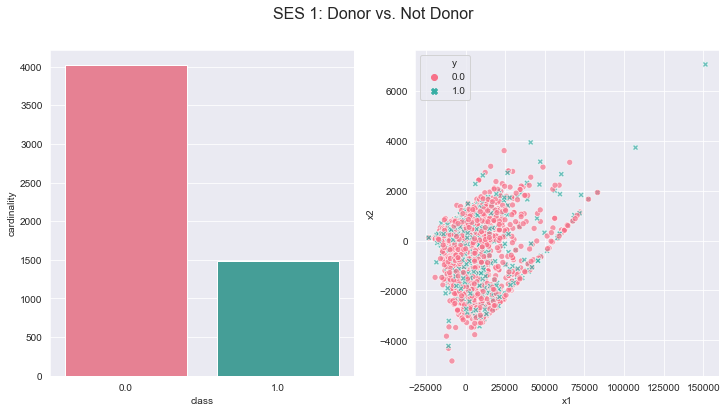

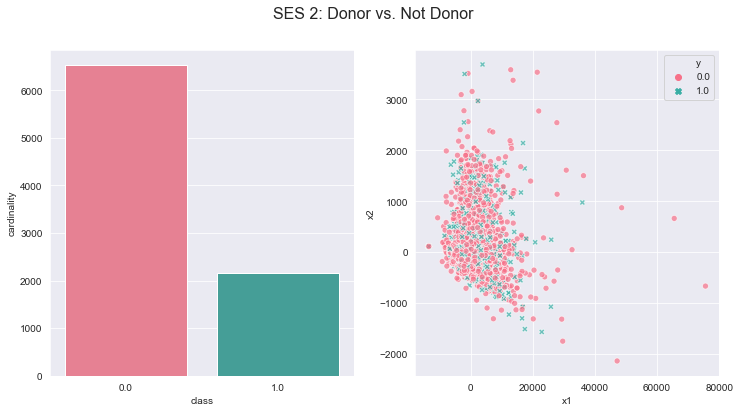

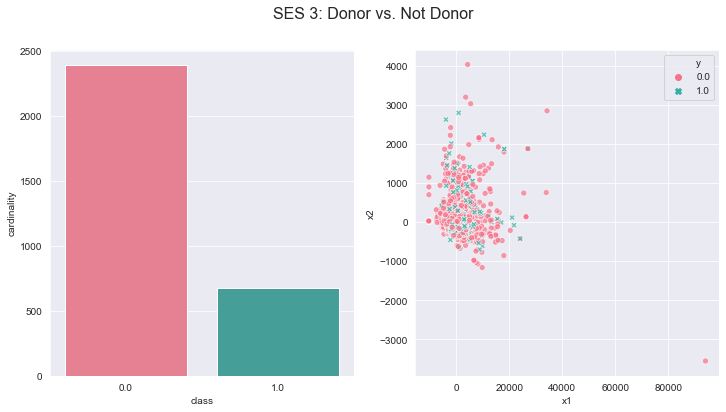

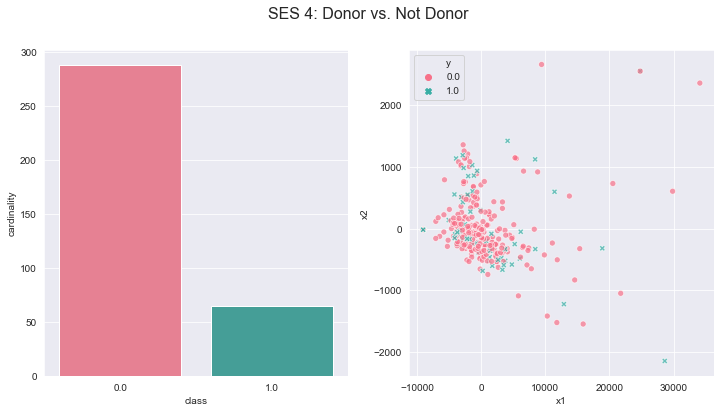

In [9]:
# Visualization of the binary classes for each SES class
# Plot 1 (left): Barplot with the cardinality of classes from y
# Plot2 (right): Scatter plot of X transformed to two dimensions using PCA
plot_cardinality_and_2d_data(X1, y1, 'SES 1: Donor vs. Not Donor')
plot_cardinality_and_2d_data(X2, y2, 'SES 2: Donor vs. Not Donor')
plot_cardinality_and_2d_data(X3, y3, 'SES 3: Donor vs. Not Donor')
plot_cardinality_and_2d_data(X4, y4, 'SES 4: Donor vs. Not Donor')

The data for the four classes is imbalanced. This is to be expected as the original dataset also showed a high imbalance level. The 'Not donors' class has considerably more datapoints than the 'Donors' class. Following the steps taken in the previous tasks, we will perform a data split with stratification and cross validation with a StratifiedKFold approach.

#### Traning and Testing Sets 

In [10]:
# Split the data - Training set: 0.75; Testing set: 0.25;

# SES Class 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, stratify=y1)
# SES Class 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, stratify=y2)
# SES Class 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42, stratify=y3)
# SES Class 4
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, random_state=42, stratify=y4)

### Binary Classification: Naive Bayes Classifier

In [11]:
## Classifier - With the parameters set at Task 1.1 (Default)
gnb = GaussianNB()

#### Cross-Validation 

In [12]:
ses_X = [X1, X2, X3, X4]
ses_y = [y1, y2, y3, y4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

for X, y, name in zip(ses_X, ses_y, names):
    f1_macro = cross_val_score(gnb, X, y, cv=10, scoring='f1_macro')
    f1_weighted = cross_val_score(gnb, X, y, cv=10, scoring = 'f1_weighted')
    recall_macro = cross_val_score(gnb, X, y, cv=10, scoring='recall_macro')
    recall_weighted  = cross_val_score(gnb, X, y, cv=10, scoring = 'recall_weighted')
    accuracy_cv = cross_val_score(gnb, X, y, cv=10, scoring='accuracy')
    
    print('Cross-Validation {name} - F1 Micro: %0.2f (+/- %0.2f)'.format(name=name) % (f1_macro.mean(), f1_macro.std() * 2))
    print('Cross-Validation {name} - F1 Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (f1_weighted.mean(), f1_weighted.std() * 2))
    print('Cross-Validation {name} - Recall Micro: %0.2f (+/- %0.2f)'.format(name=name) % (recall_macro.mean(), recall_macro.std() * 2))
    print('Cross-Validation {name} - Recall Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (recall_weighted.mean(), recall_weighted.std() * 2))
    print('Cross-Validation {name} - Accuracy: %0.2f (+/- %0.2f)'.format(name=name) % (accuracy_cv.mean(), accuracy_cv.std() * 2),'\n')

Cross-Validation SES Class 1 - F1 Micro: 0.54 (+/- 0.05)
Cross-Validation SES Class 1 - F1 Weighted: 0.63 (+/- 0.09)
Cross-Validation SES Class 1 - Recall Micro: 0.55 (+/- 0.04)
Cross-Validation SES Class 1 - Recall Weighted: 0.64 (+/- 0.10)
Cross-Validation SES Class 1 - Accuracy: 0.64 (+/- 0.10) 

Cross-Validation SES Class 2 - F1 Micro: 0.55 (+/- 0.05)
Cross-Validation SES Class 2 - F1 Weighted: 0.67 (+/- 0.10)
Cross-Validation SES Class 2 - Recall Micro: 0.56 (+/- 0.05)
Cross-Validation SES Class 2 - Recall Weighted: 0.68 (+/- 0.12)
Cross-Validation SES Class 2 - Accuracy: 0.68 (+/- 0.12) 

Cross-Validation SES Class 3 - F1 Micro: 0.54 (+/- 0.12)
Cross-Validation SES Class 3 - F1 Weighted: 0.67 (+/- 0.16)
Cross-Validation SES Class 3 - Recall Micro: 0.55 (+/- 0.09)
Cross-Validation SES Class 3 - Recall Weighted: 0.67 (+/- 0.17)
Cross-Validation SES Class 3 - Accuracy: 0.67 (+/- 0.17) 

Cross-Validation SES Class 4 - F1 Micro: 0.52 (+/- 0.14)
Cross-Validation SES Class 4 - F1 Weight

#### Training vs. Testing 

Accuracy Score Training Set SES Class 1 - F1 Macro:  0.5529575848708872
Accuracy Score Training Set SES Class 1 - F1 Weighted:  0.6523404763708666
Accuracy Score Training Set SES Class 1 - Recall Macro:  0.5517435774731678
Accuracy Score Training Set SES Class 1 - Recall Weighted:  0.6579520697167756
Accuracy Score Training Set SES Class 1 - Accuracy:  0.6579520697167756 

Accuracy Score Training Set SES Class 2 - F1 Macro:  0.5659098204980557
Accuracy Score Training Set SES Class 2 - F1 Weighted:  0.6789461678797951
Accuracy Score Training Set SES Class 2 - Recall Macro:  0.564633904322107
Accuracy Score Training Set SES Class 2 - Recall Weighted:  0.6825713409021172
Accuracy Score Training Set SES Class 2 - Accuracy:  0.6825713409021172 

Accuracy Score Training Set SES Class 3 - F1 Macro:  0.5549750399320513
Accuracy Score Training Set SES Class 3 - F1 Weighted:  0.6912841438742962
Accuracy Score Training Set SES Class 3 - Recall Macro:  0.5557536880788662
Accuracy Score Training Se

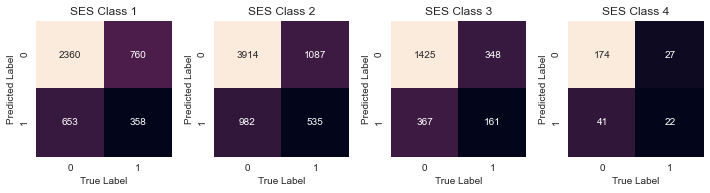

In [13]:
ses_X_train = [X_train1, X_train2, X_train3, X_train4]
ses_y_train = [y_train1, y_train2, y_train3, y_train4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for X_train, y_train, name, i in zip(ses_X_train, ses_y_train, names, range(len(names))):
    
    gnb = gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_train)
        
    f1_macro = f1_score(y_train, y_pred, average='macro')
    f1_wighted = f1_score(y_train, y_pred, average='weighted')
    recall_macro = recall_score(y_train, y_pred, average='macro')
    recall_wighted = recall_score(y_train, y_pred, average='weighted')
    accuracy = accuracy_score(y_train, y_pred)
        
    print('Accuracy Score Training Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Training Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Training Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Training Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Training Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
        
    cm_train = confusion_matrix(y_train, y_pred)
    
    sns.heatmap(cm_train.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

Accuracy Score Testing Set SES Class 1 - F1 Macro:  0.5464376019690182
Accuracy Score Testing Set SES Class 1 - F1 Weighted:  0.6501578254338901
Accuracy Score Testing Set SES Class 1 - Recall Macro:  0.5452134488846092
Accuracy Score Testing Set SES Class 1 - Recall Weighted:  0.6586782861292665
Accuracy Score Testing Set SES Class 1 - Accuracy:  0.6586782861292665 

Accuracy Score Testing Set SES Class 2 - F1 Macro:  0.5826300150267205
Accuracy Score Testing Set SES Class 2 - F1 Weighted:  0.687452887304037
Accuracy Score Testing Set SES Class 2 - Recall Macro:  0.5828361150375122
Accuracy Score Testing Set SES Class 2 - Recall Weighted:  0.6870685687988956
Accuracy Score Testing Set SES Class 2 - Accuracy:  0.6870685687988956 

Accuracy Score Testing Set SES Class 3 - F1 Macro:  0.5619047619047619
Accuracy Score Testing Set SES Class 3 - F1 Weighted:  0.699237351190476
Accuracy Score Testing Set SES Class 3 - Recall Macro:  0.5614007475900059
Accuracy Score Testing Set SES Class 3 -

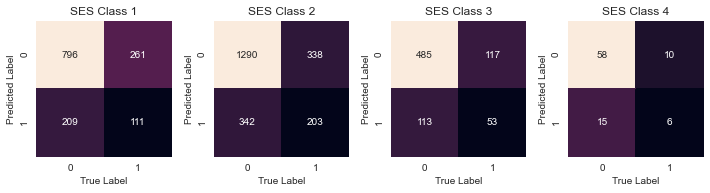

In [14]:
ses_X_train = [X_train1, X_train2, X_train3, X_train4]
ses_y_train = [y_train1, y_train2, y_train3, y_train4]
ses_X_test = [X_test1, X_test2, X_test3, X_test4]
ses_y_test = [y_test1, y_test2, y_test3, y_test4]
names = ['SES Class 1', 'SES Class 2','SES Class 3','SES Class 4']

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for X_test, y_test, X_train, y_train, name, i in zip(ses_X_test, ses_y_test, ses_X_train, ses_y_train, names, range(len(names))):
    
    gnb = gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
        
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_wighted = f1_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_wighted = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
        
    print('Accuracy Score Testing Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Testing Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Testing Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Testing Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Testing Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
        
    cm_test = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

### Results and Discussion  

The results achieved in this task are highly derivative from the results obtained in Task 1.1. The model classifies correctly the first class (Class 0) for all the SES classes. However, it does not perform so well classifying Class 1. Again, this is probably due to the imbalanced data. Nevertheless, the F1 Weigthed scores are above average and it appears that the model is able to learn. On the other hand, the classifier seems to be sensitive to the small sample size of SES Class 4. In both confusion matrixes - training and testing sets - the difference between the number of true and false positives is lower than the other SES classes. Overall, these results follow our initial expectations, as they are similar to the binary classification of the entire dataset.